In [ ]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio

class AudioUtil():
  # ----------------------------
  # Load an audio file. Return the signal as a tensor and the sample rate
  # ----------------------------
  @staticmethod
  def open(audio_file):
    sig, sr = torchaudio.load(audio_file)
    return (sig, sr)

 # ----------------------------
  # Convert the given audio to the desired number of channels
  # ----------------------------
  @staticmethod
  def rechannel(aud, new_channel):
      sig, sr = aud

      if (sig.shape[0] == new_channel):
        ##############
          return aud

      if (new_channel == 1):
        # Convert from stereo to mono by selecting only the first channel
          resig = sig[:1, :]
      else:
        # Convert from mono to stereo by duplicating the first channel
          resig = torch.cat([sig, sig])

      return ((resig, sr))

  # ----------------------------
    # Since Resample applies to a single channel, we resample one channel at a time
    # ----------------------------
  @staticmethod
  def resample(aud, newsr):
      sig, sr = aud

      if (sr == newsr):
        #################
          return aud

      num_channels = sig.shape[0]
      # Resample first channel
      resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
      if (num_channels > 1):
        # Resample the second channel and merge both channels
          retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
          resig = torch.cat([resig, retwo])

      return ((resig, newsr))

  # ----------------------------
    # Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds
    # ----------------------------
  @staticmethod
  def pad_trunc(aud, max_ms):
      sig, sr = aud
      num_rows, sig_len = sig.shape
      max_len = sr//1000 * max_ms

      if (sig_len > max_len):
        # Truncate the signal to the given length
          sig = sig[:,:max_len]

      elif (sig_len < max_len):
        # Length of padding to add at the beginning and end of the signal
          pad_begin_len = random.randint(0, max_len - sig_len)
          pad_end_len = max_len - sig_len - pad_begin_len

        # Pad with 0s
          pad_begin = torch.zeros((num_rows, pad_begin_len))
          pad_end = torch.zeros((num_rows, pad_end_len))

          sig = torch.cat((pad_begin, sig, pad_end), 1)
        
      return (sig, sr)

  # ----------------------------
    # Shifts the signal to the left or right by some percent. Values at the end
    # are 'wrapped around' to the start of the transformed signal.
    # ----------------------------
  @staticmethod
  def time_shift(aud, shift_limit):
      sig,sr = aud
      _, sig_len = sig.shape
      shift_amt = int(random.random() * shift_limit * sig_len)
      return (sig.roll(shift_amt), sr)

  # ----------------------------
    # Generate a Spectrogram
    # ----------------------------
  @staticmethod
  def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
      sig,sr = aud
      top_db = 80

      # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
      spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

      # Convert to decibels
      spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
      return (spec)

  # ----------------------------
    # Augment the Spectrogram by masking out some sections of it in both the frequency
    # dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
    # overfitting and to help the model generalise better. The masked sections are
    # replaced with the mean value.
    # ----------------------------
  @staticmethod
  def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
      _, n_mels, n_steps = spec.shape
      mask_value = spec.mean()
      aug_spec = spec

      freq_mask_param = max_mask_pct * n_mels
      for _ in range(n_freq_masks):
          aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

      time_mask_param = max_mask_pct * n_steps
      for _ in range(n_time_masks):
          aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

      return aug_spec

In [ ]:
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio

# ----------------------------
# Sound Dataset
# ----------------------------
class SoundDS(Dataset):
    def __init__(self, df, data_path):
        self.df = df
        self.data_path = str(data_path)
        self.duration = 4000
        self.sr = 44100
        self.channel = 2
        self.shift_pct = 0.4
            
  # ----------------------------
  # Number of items in dataset
  # ----------------------------
    def __len__(self):
        return len(self.df)    
    
  # ----------------------------
  # Get i'th item in dataset
  # ----------------------------
    def __getitem__(self, idx):
        # Absolute file path of the audio file - concatenate the audio directory with
        # the relative path
        audio_file = self.data_path + self.df.loc[idx, 'full_file_path']
        # Get the Class ID
        class_id = self.df.loc[idx, 'class']

        aud = AudioUtil.open(audio_file)
        # Some sounds have a higher sample rate, or fewer channels compared to the
        # majority. So we make all sounds have the same number of channels and same 
        # sample rate. Unless the sample rate is the same, the pad_trunc will still
        # result in arrays of different lengths, even though the sound duration is
        # the same.
        reaud = AudioUtil.resample(aud, self.sr)
        rechan = AudioUtil.rechannel(reaud, self.channel)

        dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
        shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
        sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
        aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

        return aug_sgram, class_id


In [ ]:
import pandas as pd
import librosa
import os

# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Define the directories containing audio files
dir1 = '/content/drive/MyDrive/Capstone/data/emergency_sounds'
dir2 = '/content/drive/MyDrive/Capstone/data/general_sounds'

# Create an empty list to store the file information
file_info = []

# Loop through the files in each directory
for dir in [dir1, dir2]:
    for file in os.listdir(dir):
        if file.endswith('.wav'):  # Only consider .wav files
            # Load the audio file and compute its duration
            audio_path = os.path.join(dir, file)
            y, sr = librosa.load(audio_path, sr=None)
            duration = librosa.get_duration(y=y, sr=sr)
            
            # Store the file information in a dictionary
            file_dict = {
                'filename': file,
                'duration': duration,
                'class': os.path.basename(dir),
                'folder_path': dir,
                'full_file_path': audio_path
            }
            
            # Add the file information to the list
            file_info.append(file_dict)

# Create a DataFrame from the file information list
df = pd.DataFrame(file_info)

# Print the DataFrame
print(df)

                                filename   duration             class  \
0                    siren-firetruck.wav  23.328542  emergency_sounds   
1            distant-ambulance-siren.wav  24.000000  emergency_sounds   
2                   german-ambulance.wav  16.467528  emergency_sounds   
3                ambulance-in-oradea.wav  25.000000  emergency_sounds   
4    one-police-siren-with-long-tail.wav  53.050023  emergency_sounds   
..                                   ...        ...               ...   
215              xmas-bellis2-120bpm.wav  34.063688    general_sounds   
216       Woodpecker Pecking on Tree.wav   5.564083    general_sounds   
217             water-at-the-beach-2.wav  29.561021    general_sounds   
218                       Woodpecker.wav   1.724083    general_sounds   
219          Woodpecker Pecking Fast.wav   1.985313    general_sounds   

                                           folder_path  \
0    /content/drive/MyDrive/Capstone/data/emergency...   
1    /c

In [ ]:
df = df[["full_file_path", "class"]]

In [ ]:
df['class'] = df['class'].map({'emergency_sounds': 1, 'general_sounds': 0})

In [ ]:
df

,full_file_path,class
0,/content/drive/MyDrive/Capstone/data/emergency...,1
1,/content/drive/MyDrive/Capstone/data/emergency...,1
2,/content/drive/MyDrive/Capstone/data/emergency...,1
3,/content/drive/MyDrive/Capstone/data/emergency...,1
4,/content/drive/MyDrive/Capstone/data/emergency...,1
...,...,...
215,/content/drive/MyDrive/Capstone/data/general_s...,0
216,/content/drive/MyDrive/Capstone/data/general_s...,0
217,/content/drive/MyDrive/Capstone/data/general_s...,0
218,/content/drive/MyDrive/Capstone/data/general_s...,0


In [ ]:
from torch.utils.data import random_split
data_path = ""
myds = SoundDS(df, data_path)

# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)

In [ ]:
val_ds

In [ ]:
import torch.nn.functional as F
from torch.nn import init
import torch.nn as nn

# ----------------------------
# Audio Classification Model
# ----------------------------
class AudioClassifier (nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Third Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Fourth Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=10)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

# Create the model and put it on the GPU if available
model = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# Check that it is on Cuda
next(model.parameters()).device

device(type='cpu')

In [ ]:
import pickle

# ----------------------------
# evaluation loop
# ----------------------------
def evaluate(model, val_dl, criterion):
    # Set model to evaluation mode
    model.eval()

    # Keep track of total loss
    total_loss = 0.0
    correct_prediction = 0
    total_prediction = 0

    # Disable gradient computation to save memory and computation time
    with torch.no_grad():
        # Iterate over validation set batches
        for data in val_dl:
            # Get the input features and target labels, and put them on the GPU
            inputs, labels = data[0].to(device), data[1].to(device)

            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Add batch loss to total loss
            total_loss += loss.item()

            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)
            # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]

    # Calculate average validation loss and accuracy
    avg_loss = total_loss / len(val_dl)
    acc = correct_prediction/total_prediction
    # Set model back to training mode
    model.train()

    return avg_loss, acc



# ----------------------------
# Training Loop
# ----------------------------
def training(model, train_dl, num_epochs):
  # Loss Function, Optimizer and Scheduler
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')
  
  # Variables to keep track of best validation loss, best validation accuracy and corresponding model
  best_val_acc = -float('inf')
  best_val_loss = float('inf')
  best_model_state = None

  # Repeat for each epoch
  for epoch in range(num_epochs):
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0

    # Repeat for each batch in the training set
    for i, data in enumerate(train_dl):
        # Get the input features and target labels, and put them on the GPU
        inputs, labels = data[0].to(device), data[1].to(device)

        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Keep stats for Loss and Accuracy
        running_loss += loss.item()

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]

        #if i % 10 == 0:    # print every 10 mini-batches
        #    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
    
    # Calculate validation loss and save model if it's the best one so far
    val_loss = evaluate(model, val_dl, criterion)[0]
    val_acc = evaluate(model, val_dl, criterion)[1]
    if (val_acc >= best_val_acc and val_loss <= best_val_loss):
        best_val_acc = val_acc
        best_val_loss = val_loss
        best_model = model
    
    # Print stats at the end of the epoch
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}, Val_Loss: {val_loss:.2f}, Val_Accuracy: {val_acc:.2f}')

    # Save the best model to a pickle file
  with open('/content/drive/MyDrive/Capstone/best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
  f.close()
num_epochs=20   # adjust as per requirement
training(model, train_dl, num_epochs)

Epoch: 0, Loss: 2.30, Accuracy: 0.11, Val_Loss: 2.26, Val_Accuracy: 0.16
Epoch: 1, Loss: 2.27, Accuracy: 0.16, Val_Loss: 2.21, Val_Accuracy: 0.23
Epoch: 2, Loss: 2.20, Accuracy: 0.38, Val_Loss: 2.09, Val_Accuracy: 0.57
Epoch: 3, Loss: 2.16, Accuracy: 0.53, Val_Loss: 2.06, Val_Accuracy: 0.59
Epoch: 4, Loss: 2.09, Accuracy: 0.58, Val_Loss: 2.03, Val_Accuracy: 0.59
Epoch: 5, Loss: 1.99, Accuracy: 0.60, Val_Loss: 1.95, Val_Accuracy: 0.61
Epoch: 6, Loss: 1.89, Accuracy: 0.62, Val_Loss: 1.88, Val_Accuracy: 0.61
Epoch: 7, Loss: 1.73, Accuracy: 0.65, Val_Loss: 1.82, Val_Accuracy: 0.70
Epoch: 8, Loss: 1.57, Accuracy: 0.69, Val_Loss: 1.58, Val_Accuracy: 0.64
Epoch: 9, Loss: 1.46, Accuracy: 0.70, Val_Loss: 1.51, Val_Accuracy: 0.64
Epoch: 10, Loss: 1.34, Accuracy: 0.69, Val_Loss: 1.39, Val_Accuracy: 0.66
Epoch: 11, Loss: 1.29, Accuracy: 0.71, Val_Loss: 1.38, Val_Accuracy: 0.52
Epoch: 12, Loss: 1.19, Accuracy: 0.69, Val_Loss: 1.33, Val_Accuracy: 0.66
Epoch: 13, Loss: 1.15, Accuracy: 0.72, Val_Loss:

In [ ]:
with open('/content/drive/MyDrive/Capstone/best_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [ ]:
# Define the directories containing unseen audio files
dir3 = '/content/drive/MyDrive/Capstone/data/unseen/unseen_emergency'
dir4 = '/content/drive/MyDrive/Capstone/data/unseen/unseen_general'

# Create an empty list to store the file information
unseen_file_info = []

# Loop through the files in each directory
for dir in [dir3, dir4]:
    for file in os.listdir(dir):
        if file.endswith('.wav'):  # Only consider .wav files
            # Load the audio file and compute its duration
            audio_path = os.path.join(dir, file)
            y, sr = librosa.load(audio_path, sr=None)
            duration = librosa.get_duration(y=y, sr=sr)
            
            # Store the file information in a dictionary
            unseen_file_dict = {
                'filename': file,
                'duration': duration,
                'class': os.path.basename(dir),
                'folder_path': dir,
                'full_file_path': audio_path
            }
            
            # Add the file information to the list
            unseen_file_info.append(unseen_file_dict)

# Create a DataFrame from the file information list
unseen_df = pd.DataFrame(unseen_file_info)

# Print the DataFrame
print(unseen_df)

                                  filename   duration             class  \
0    emergency-alarm-with-reverb-29431.wav  16.056000  unseen_emergency   
1                female-scream-1-86768.wav   2.690612  unseen_emergency   
2                  angry-mob-loop-6847.wav  11.880000  unseen_emergency   
3                    dog-barking-70772.wav  16.392000  unseen_emergency   
4                    man-scream-121085.wav   3.657143  unseen_emergency   
5   9mm-pistol-shoot-short-reverb-7152.wav   1.488980  unseen_emergency   
6                 9mm-pistol-shot-6349.wav   1.697959  unseen_emergency   
7                   cafe-ambience-9263.wav  20.427755    unseen_general   
8                   crowd_talking-6762.wav  89.904000    unseen_general   
9                child-laughing-113112.wav  10.057143    unseen_general   
10              short-crowd-cheer-6713.wav   7.944000    unseen_general   
11                 laughing-man-117725.wav   4.414694    unseen_general   
12               possesse

In [ ]:
unseen_df = unseen_df[["full_file_path", "class"]]

In [ ]:
unseen_df['class'] = unseen_df['class'].map({'unseen_emergency': 1, 'unseen_general': 0})

In [ ]:
test_df = SoundDS(unseen_df, data_path)

In [ ]:
test_dl = torch.utils.data.DataLoader(test_df, batch_size=16, shuffle=False)

In [ ]:
# ----------------------------
# Inference
# ----------------------------
def inference (model, test_dl):
  correct_prediction = 0
  total_prediction = 0

  # Disable gradient updates
  with torch.no_grad():
    for data in test_dl:
      # Get the input features and target labels, and put them on the GPU
      inputs, labels = data[0].to(device), data[1].to(device)

      # Normalize the inputs
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s

      # Get predictions
      outputs = model(inputs)

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
      # Count of predictions that matched the target label
      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]
    
  acc = correct_prediction/total_prediction
  print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')

# Run inference on trained model with the validation set
inference(model, test_dl)

Accuracy: 0.43, Total items: 14


In [ ]:
from sklearn.metrics import classification_report
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_dl:
        # Forward pass
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        # Save true and predicted labels
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.71      0.71      0.71         7
           1       0.71      0.71      0.71         7

    accuracy                           0.71        14
   macro avg       0.71      0.71      0.71        14
weighted avg       0.71      0.71      0.71        14



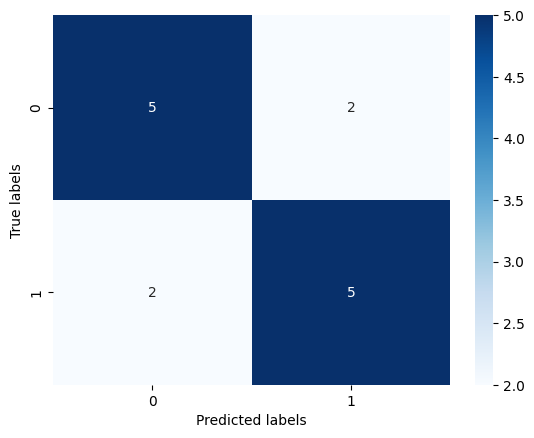

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()
